In [1]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.metrics import accuracy_score,mean_squared_error,log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from IPython.display import HTML
import seaborn as sns
from tqdm import tqdm_notebook
import time

In [2]:
torch.manual_seed(0)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [4]:
data,labels=make_blobs(1200,2,4,random_state=0)

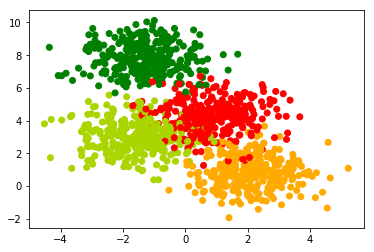

In [5]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [6]:
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,stratify=labels)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(900, 2) (300, 2) (900,) (300,)


# Using tensors and autograd

In [7]:
X_train,X_val,Y_train,Y_val = map(torch.tensor,(X_train,X_val,Y_train,Y_val))
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

torch.Size([900, 2]) torch.Size([300, 2]) torch.Size([900]) torch.Size([300])


In [8]:
def model(x):
    a1 = torch.matmul(x,w1) + b1
    h1 = a1.sigmoid()
    a2 = torch.matmul(h1,w2) + b2
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [9]:
y_hat=torch.tensor([[0.1,0.2,.3,.4],[.8,.1,.05,.05]])
y=torch.tensor([2,0])
(-y_hat[range(y_hat.shape[0]),y].log()).mean().item()

0.7135581970214844

In [10]:
(torch.argmax(y_hat,axis=1)==y).float().mean().item()

0.5

In [11]:
def loss_fn(y_hat,y):
    return -(y_hat[range(y.shape[0]),y].log()).mean()

In [12]:
def accuracy(y_hat,y):
    pred = torch.argmax(y_hat,axis=1)
    return (pred == y).float().mean()

loss before training 1.5558706521987915
loss after training 1.2337337732315063


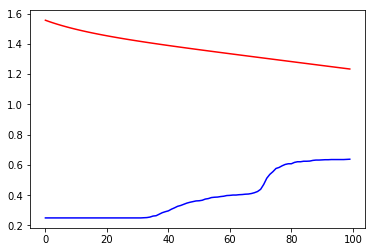

In [13]:
torch.manual_seed(0)
w1 = torch.randn(2,2)/math.sqrt(2)
w1.requires_grad_()
b1 = torch.zeros(2,requires_grad=True)

w2 = torch.randn(2,4)/math.sqrt(2)
w2.requires_grad_()
b2 = torch.zeros(4,requires_grad=True)

lr = 0.1
epoch = 100
X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for i in range(epoch):
    y_hat = model(X_train)
    loss = loss_fn(y_hat,Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat,Y_train))
    
    with torch.no_grad():
        w1 -= w1.grad * lr
        b1 -= b1.grad * lr
        w2 -= w2.grad * lr
        b2 -= b2.grad * lr
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()

        
print("loss before training",loss_arr[0])
print("loss after training",loss_arr[-1])
plt.plot(loss_arr , 'red')
plt.plot(acc_arr , 'b')
plt.show()

# Using NN.functional

In [14]:
import torch.nn.functional as F


loss before training 1.4129451513290405
loss after training 1.0024715662002563
Accuracy 0.754444420337677


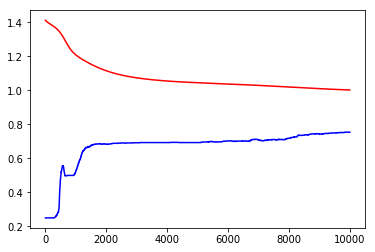

In [15]:
torch.manual_seed(0)
w1 = torch.randn(2,2)/math.sqrt(2)
w1.requires_grad_()
b1 = torch.zeros(2,requires_grad=True)

w2 = torch.randn(2,4)/math.sqrt(2)
w2.requires_grad_()
b2 = torch.zeros(4,requires_grad=True)

lr = 0.1
epoch = 10000
X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for i in tqdm_notebook(range(epoch),unit='epoch'):
    y_hat = model(X_train)
    loss = F.cross_entropy(y_hat,Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat,Y_train))
    
    with torch.no_grad():
        w1 -= w1.grad * lr
        b1 -= b1.grad * lr
        w2 -= w2.grad * lr
        b2 -= b2.grad * lr
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()

        
print("loss before training",loss_arr[0])
print("loss after training",loss_arr[-1])
print("Accuracy",acc_arr[-1].item())
plt.plot(loss_arr , 'red')
plt.plot(acc_arr , 'b')
plt.show()



In [16]:
enc=OneHotEncoder()

In [17]:
Y_train_oh = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_train_oh = torch.tensor(Y_train_oh)
Y_train_oh.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


torch.Size([900, 4])

# Using NN parameter

In [18]:
import torch.nn as nn

In [19]:
class first_torch_network(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.w1 = nn.Parameter(torch.randn(2,2)/math.sqrt(2))
        self.b1 = nn.Parameter(torch.zeros(2))

        self.w2 = nn.Parameter(torch.randn(2,4)/math.sqrt(2))
        self.b2 = nn.Parameter(torch.zeros(4))
        
    def forward(self,X):
        a1 = torch.matmul(X,self.w1) + self.b1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1,self.w2) + self.b2
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2
    

In [20]:
model = first_torch_network()

In [21]:
def fit(epoch=1000,lr = 0.2):
    loss_arr = []
    acc_arr = []

    for i in tqdm_notebook(range(epoch),unit='epoch'):
        y_hat = model(X_train)
        loss = F.cross_entropy(y_hat,Y_train)
        loss.backward()
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat,Y_train))

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
            model.zero_grad()


    print("loss before training",loss_arr[0])
    print("loss after training",loss_arr[-1])
    print("Accuracy",acc_arr[-1].item())
    plt.plot(loss_arr , 'red')
    plt.plot(acc_arr , 'b')
    plt.show()



loss before training 1.4129451513290405
loss after training 1.115899682044983
Accuracy 0.6833333373069763


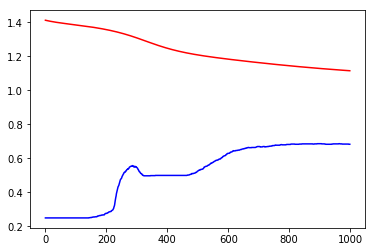

In [22]:
fit()

# Using nn.linear and nn.optim

In [23]:
class first_torch_network_linear(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2,2)
        self.lin2 = nn.Linear(2,4)
        
    def forward(self,X):
        a1 = self.lin1(X)
        h1 = a1.sigmoid()
        a2 = self.lin2(h1)
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [24]:
model = first_torch_network_linear()


loss before training 1.3954243659973145
loss after training 1.1456873416900635
Accuracy 0.6433333158493042


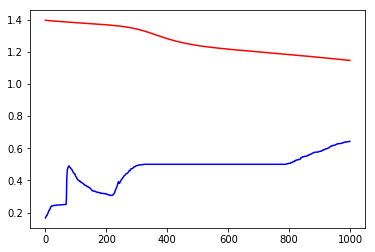

In [25]:
fit()

In [26]:
import torch.optim as optim

In [27]:
def fit_optim(epoch=1000,lr = 0.2):
    loss_arr = []
    acc_arr = []
    opt = optim.Adam(model.parameters(),lr = lr)

    for i in tqdm_notebook(range(epoch),unit='epoch'):
        y_hat = model(X_train)
        loss = F.cross_entropy(y_hat,Y_train)
        
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat,Y_train))

        """with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
            model.zero_grad() """
        loss.backward()
        opt.step()
        opt.zero_grad()


    print("loss before training",loss_arr[0])
    print("loss after training",loss_arr[-1])
    print("Accuracy",acc_arr[-1].item())
    plt.plot(loss_arr , 'red')
    plt.plot(acc_arr , 'b')
    plt.show()



loss before training 1.3954243659973145
loss after training 0.8128381967544556
Accuracy 0.9333333373069763


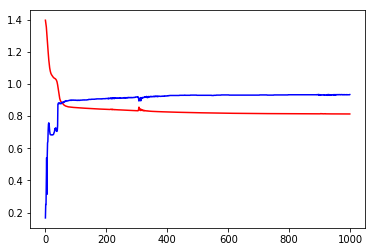

In [28]:
model = first_torch_network_linear()
fit_optim()

# Using NN sequential

In [29]:
class first_torch_network_linear_sequential(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.seq = nn.Sequential(nn.Linear(2,3),nn.Tanh(),nn.Linear(3,1),nn.Sigmoid(),nn.Linear(1,4),nn.Softmax())
        
    def forward(self,X):
        return self.seq(X)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimensio

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



loss before training 1.394566297531128
loss after training 0.9928781390190125
Accuracy 0.746666669845581


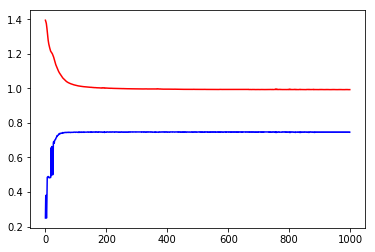

In [30]:
X_train = X_train.float()
Y_train = Y_train.long()
model = first_torch_network_linear_sequential()
fit_optim()

In [31]:
import warnings
warnings.filterwarnings('ignore')


loss before training 1.394566297531128
loss after training 0.9928781390190125
Accuracy 0.746666669845581


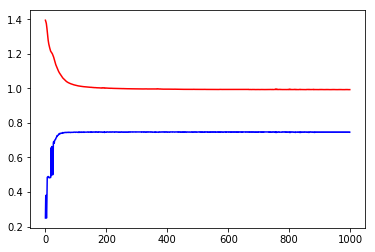

In [32]:
model = first_torch_network_linear_sequential()
fit_optim()

In [33]:
def fit_structured(x,y,model,opt,loss_fn,epoch=1000):
    for i in tqdm_notebook(range(epoch),unit='epoch'):
        loss = loss_fn(model(x),y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item()

In [34]:
model = first_torch_network_linear_sequential()
loss_fn = F.cross_entropy
opt = optim.SGD(model.parameters(),0.1)
fit_structured(X_train,Y_train,model,opt,loss_fn)

1.3565380573272705

# complex dataset structured for testing

In [35]:
data,labels = make_blobs(2000,12,16,random_state = 0)

In [36]:
X_train,X_val,Y_train,Y_val = train_test_split(data,labels,stratify=labels,random_state = 0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(1500, 12) (500, 12) (1500,) (500,)


In [37]:
X_train,X_val,Y_train,Y_val = map(torch.tensor,(X_train,X_val,Y_train,Y_val))
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

torch.Size([1500, 12]) torch.Size([500, 12]) torch.Size([1500]) torch.Size([500])


In [38]:
X_train = X_train.float()
Y_train = Y_train.long()

In [39]:
class first_torch_network_linear_sequential_complex_dataset(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.seq = nn.Sequential(nn.Linear(12,3),nn.Tanh(),nn.Linear(3,1),nn.Sigmoid(),nn.Linear(1,16),nn.Softmax())
        
    def forward(self,X):
        return self.seq(X)

In [40]:
def fit_optim_complex(epoch=100000,lr = 0.01):
    loss_arr = []
    acc_arr = []
    opt = optim.SGD(model.parameters(),lr = lr)

    for i in tqdm_notebook(range(epoch),unit='epoch'):
        y_hat = model(X_train)
        loss = F.cross_entropy(y_hat,Y_train)
        
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat,Y_train))
        
        loss.backward()
        opt.step()
        opt.zero_grad()


    print("loss before training",loss_arr[0])
    print("loss after training",loss_arr[-1])
    print("Accuracy",acc_arr[-1].item())
    plt.plot(loss_arr , 'red')
    plt.plot(acc_arr , 'b')
    plt.show()



loss before training 2.7739124298095703
loss after training 2.7286529541015625
Accuracy 0.12533333897590637


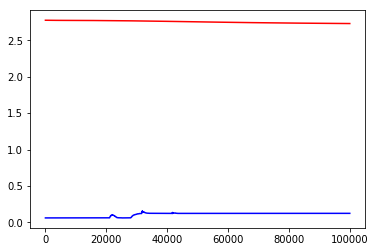

In [41]:
model = first_torch_network_linear_sequential_complex_dataset()
fit_optim_complex()

## Increasing hidden layers and neurons

In [42]:
class first_torch_network_linear_sequential_complex_dataset(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.seq = nn.Sequential(nn.Linear(12,32),nn.Tanh(),nn.Linear(32,64),nn.Sigmoid(),nn.Linear(64,128),nn.Sigmoid()
                                 ,nn.Linear(128,16),nn.Softmax())
        
    def forward(self,X):
        return self.seq(X)


loss before training 2.7725319862365723
loss after training 2.067448854446411
Accuracy 0.812666654586792


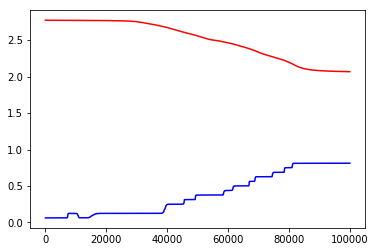

In [43]:
model = first_torch_network_linear_sequential_complex_dataset()
fit_optim_complex()